In [1]:
#Importing necessary libraries, reading in data, defining useful functions, dropping unneeded data

import pandas as pd
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
import numpy as np
%matplotlib inline
plt.style.use('ggplot')

#Function that takes model, fits and scores, prints output as well as execution time
def print_score(name, model, X_train, X_test, y_train, y_test):
    start_time = time.time()
    model.fit(X_train, y_train)
    print(name,": ", model.score(X_test, y_test), "--- %s seconds ---" % (time.time() - start_time))

#Cross Validation Function
def cross_val(name, model, X, y, num):
    start_time = time.time()
    scores = cross_val_score(model, X, y, cv=num)
    tot_score = np.mean(scores)
    print(name,": ", tot_score, "--- %s seconds ---" % (time.time() - start_time))
    return tot_score

#making the data logarithmic
def make_logarithmic(df):
    temp = df + 1
    temp = np.log(temp)
    return StandardScaler().fit_transform(temp)

def make_logarithmic_pd(df):
    temp = df + 1
    temp = np.log(temp)
    return pd.DataFrame(StandardScaler().fit_transform(temp))
    
#Read the file  
df = pd.read_csv(r'USvideos.csv')

#Drop the unused data
df = df.drop(['video_id',  'title', 'channel_title','tags',
              'thumbnail_link', 'comments_disabled', 'ratings_disabled',
              'video_error_or_removed',
              'description'], axis=1)

In [2]:
#Creating a new column for 'trending time' and dropping 'publish time'

from datetime import timedelta 
#import trending date and add 1 day to it, so the publish date becomes always before the trending date.
trending_dates = pd.to_datetime("20"+ df['trending_date'] , format="%Y.%d.%m") + timedelta(days=1)

#import publish_date
publish_times = pd.to_datetime(df['publish_time'] , infer_datetime_format = True)

#Take the difference between the publishing date and trending date "how long does the video take to be in trending"
trending_time = trending_dates.subtract(publish_times)
# add a coloumn trending time (in second)
df['trending_time'] =  trending_time.dt.total_seconds()
#Drop publish time because we will not use it. We will use trending_time instead
df = df.drop(['publish_time'], axis=1)

print(df.describe())
# List of unique trending date
listDate = df.trending_date.unique().tolist()
#List of dataframes. Each data frame contains one trending date.
DataFrames = []
for i in listDate:
    DataFrames.append(df.loc[df.trending_date==i])

print(len(DataFrames))

        category_id         views         likes      dislikes  comment_count  \
count  40949.000000  4.094900e+04  4.094900e+04  4.094900e+04   4.094900e+04   
mean      19.972429  2.360785e+06  7.426670e+04  3.711401e+03   8.446804e+03   
std        7.568327  7.394114e+06  2.288853e+05  2.902971e+04   3.743049e+04   
min        1.000000  5.490000e+02  0.000000e+00  0.000000e+00   0.000000e+00   
25%       17.000000  2.423290e+05  5.424000e+03  2.020000e+02   6.140000e+02   
50%       24.000000  6.818610e+05  1.809100e+04  6.310000e+02   1.856000e+03   
75%       25.000000  1.823157e+06  5.541700e+04  1.938000e+03   5.755000e+03   
max       43.000000  2.252119e+08  5.613827e+06  1.674420e+06   1.361580e+06   

       trending_time  
count   4.094900e+04  
mean    1.488113e+06  
std     1.261553e+07  
min     3.959600e+04  
25%     2.952010e+05  
50%     5.003950e+05  
75%     7.850890e+05  
max     3.642321e+08  
205


Text(0.5, 1.0, 'Likes vs Category')

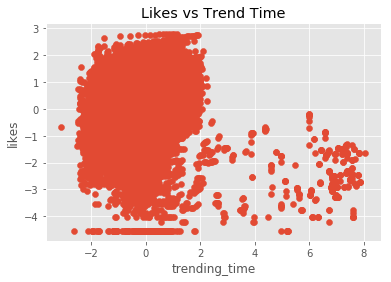

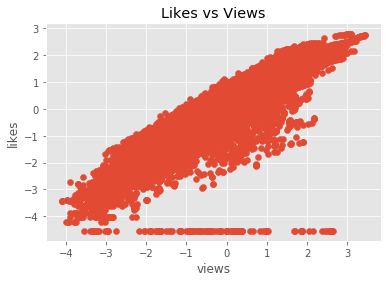

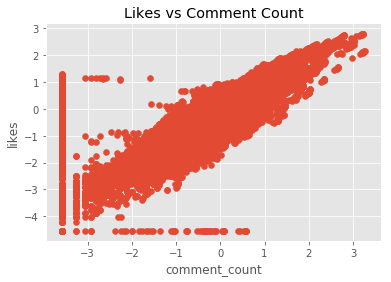

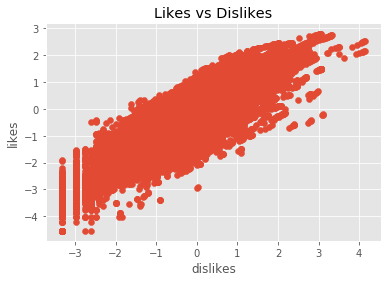

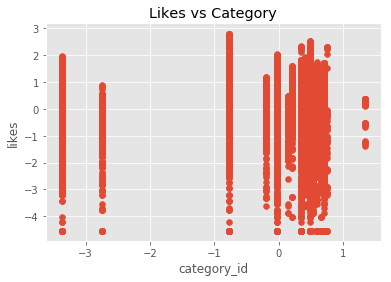

In [3]:
#Plotting different features against 'likes' to see correlation

temp = df.loc[:, ['views', 'comment_count', 'dislikes', 'category_id', 'trending_time', 'likes']].values
temp = make_logarithmic(temp)
temp = pd.DataFrame(data = temp, columns = ['views', 'comment_count', 'dislikes', 'category_id', 'trending_time', 'likes'])

fig, ax = plt.subplots()
ax.scatter(temp['trending_time'], temp['likes'])
ax.set_xlabel('trending_time')
ax.set_ylabel('likes')
ax.set_title('Likes vs Trend Time')

fig, ax = plt.subplots()
ax.scatter(temp['views'], temp['likes'])
ax.set_xlabel('views')
ax.set_ylabel('likes')
ax.set_title('Likes vs Views')

fig, ax = plt.subplots()
ax.scatter(temp['comment_count'], temp['likes'])
ax.set_xlabel('comment_count')
ax.set_ylabel('likes')
ax.set_title('Likes vs Comment Count')

fig, ax = plt.subplots()
ax.scatter(temp['dislikes'], temp['likes'])
ax.set_xlabel('dislikes')
ax.set_ylabel('likes')
ax.set_title('Likes vs Dislikes')

fig, ax = plt.subplots()
ax.scatter(temp['category_id'], temp['likes'])
ax.set_xlabel('category_id')
ax.set_ylabel('likes')
ax.set_title('Likes vs Category')


In [4]:
#Using the data from 'views', 'comment_count', and 'dislikes' for regression models

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

X = df.loc[:, ['views', 'comment_count', 'dislikes', 'category_id']].values
y = df.loc[:, ['likes']].values.ravel()
X = make_logarithmic(X)
y = make_logarithmic(pd.DataFrame(y))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 69)

forest = RandomForestRegressor(max_depth = 5)
print_score('Random Forest',forest, X_train, X_test, y_train, y_test)

#nn = MLPRegressor()
#print_score('Multi Layer Perceptron',nn, X_train, X_test, y_train, y_test)
#This is commented out because it took 150+ seconds to run

lr = LinearRegression()
print_score('Linear Regression',lr, X_train, X_test, y_train, y_test)

#svm = SVC(kernel='linear', C=1E10)
#print_score('Support Vector Classifier',svm, X_train, X_test, y_train, y_test)
#Takes too long

#nb = GaussianNB()
#print_score('Naive Bayes',nb, X_train, X_test, y_train, y_test)
#Takes too long

#ab = AdaBoostClassifier()
#print_score('AdaBoost',ab, X_train, X_test, y_train, y_test)
#Breaks jupyter

#knn = KNeighborsClassifier(3)
#print_score('Nearest Neighbor',knn, X_train, X_test, y_train, y_test)

#qda = QuadraticDiscriminantAnalysis()
#print_score('Quadratic DA',qda, X_train, X_test, y_train, y_test)
#Doesn't compile

/srv/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/srv/conda/lib/python3.6/site-packages/ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


Random Forest :  0.8798446475586443 --- 0.41924619674682617 seconds ---
Linear Regression :  0.8251779999507276 --- 0.013246536254882812 seconds ---


[0.53019131 0.20727977 0.18726867 0.04852822 0.02673203]


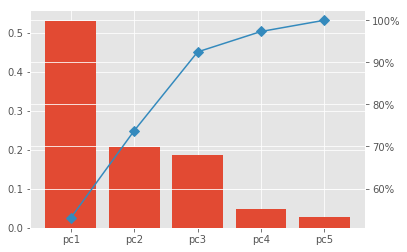

In [ ]:
#Performing PCA and creating Pareto Chart

from sklearn.decomposition import PCA

features = ['views', 'dislikes', 'comment_count', 'trending_time', 'category_id']
# Separating out the features
x = df.loc[:, features].values
# Separating out the target
y = df.loc[:,['likes']].values.ravel()
# Standardizing the features
x = make_logarithmic(x)
y = make_logarithmic(pd.DataFrame(y))

pca = PCA()

pca.fit_transform(x)
transformed_data = pca.fit_transform(x)
transformed_df = pd.DataFrame(data = transformed_data,
                              columns = ['pc1', 'pc2','pc3','pc4','pc5'])
print(pca.explained_variance_ratio_)

from matplotlib.ticker import PercentFormatter

temp_df = pd.DataFrame({'Variance Ratio': pca.explained_variance_ratio_})
temp_df.index = ['pc1', 'pc2','pc3','pc4','pc5']
temp_df = temp_df.sort_values(by='Variance Ratio',ascending=False)
temp_df["cumpercentage"] = temp_df["Variance Ratio"].cumsum()/temp_df["Variance Ratio"].sum()*100


fig, ax = plt.subplots()
ax.bar(temp_df.index, temp_df["Variance Ratio"], color="C0")
ax2 = ax.twinx()
ax2.plot(temp_df.index, temp_df["cumpercentage"], color="C1", marker="D", ms=7)
ax2.yaxis.set_major_formatter(PercentFormatter())

In [ ]:
#Using the Pricipal Components and cross validation

for x in range(0,5):
    results = ["Linear Regression", "Random Forest", "Multi Layer Perceptron"]
    scores = []
    print("Loop: ", x)
    a = ['pc1', 'pc2','pc3','pc4','pc5']
    a = a[0:5-x]
    print(a)
    X = transformed_df.loc[:, a]

    scores.append(cross_val("Linear Regression", lr, X, y, 10))
    scores.append(cross_val("Random Forest", forest, X, y, 10))
    #scores.append(cross_val("Nearest Neighbor", knn, X, y, 10))
    #This one compiles, but its performance is terrible and takes 20+ seconds per iteration
    
    #scores_MLP = cross_val_score(MLPRegressor(), X, y, cv=10)
    #scores.append(np.mean(scores_LR))
    #scores_SVR = cross_val_score(SVR(gamma='scale', C=1.0, epsilon=0.2), X, y, cv=2)
    #scores.append(np.mean(scores_LR))
    print("The best result using ", 5-x," components is " ,results[scores.index(max(scores))]," with a value of ", max(scores))

Loop:  0
['pc1', 'pc2', 'pc3', 'pc4', 'pc5']
Linear Regression :  0.7693929455693858 --- 0.8882937431335449 seconds ---


/srv/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/srv/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/srv/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/srv/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 

Random Forest :  0.813243758701144 --- 9.072604179382324 seconds ---
The best result using  5  components is  Random Forest  with a value of  0.813243758701144
Loop:  1
['pc1', 'pc2', 'pc3', 'pc4']
Linear Regression :  0.7622676270899531 --- 0.9310009479522705 seconds ---


/srv/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/srv/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/srv/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/srv/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 

Random Forest :  0.7729496196238068 --- 6.98001503944397 seconds ---
The best result using  4  components is  Random Forest  with a value of  0.7729496196238068
Loop:  2
['pc1', 'pc2', 'pc3']
Linear Regression :  0.7635334986092099 --- 0.6096580028533936 seconds ---


/srv/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/srv/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/srv/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/srv/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 

Random Forest :  0.768671916139873 --- 5.288036584854126 seconds ---
The best result using  3  components is  Random Forest  with a value of  0.768671916139873
Loop:  3
['pc1', 'pc2']
Linear Regression :  0.762573296826666 --- 0.055588483810424805 seconds ---


/srv/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/srv/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/srv/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/srv/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 

Random Forest :  0.7675375342135604 --- 3.607203483581543 seconds ---
The best result using  2  components is  Random Forest  with a value of  0.7675375342135604
Loop:  4
['pc1']
Linear Regression :  0.7507265075432719 --- 0.04781341552734375 seconds ---


/srv/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/srv/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/srv/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/srv/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 

Random Forest :  0.7612900542803115 --- 2.2429862022399902 seconds ---
The best result using  1  components is  Random Forest  with a value of  0.7612900542803115


In [ ]:
#Comparing individual days (sets of 5 days of data)

X = df.loc[:, ['views', 'comment_count', 'dislikes', 'category_id']]
y = df.loc[:, ['likes']]
itr = 0
days = ['Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun', 'Mon']
for day in days:
    a = 0 + itr
    b = 200 + itr
    frames_x = []
    frames_y = []
    for x in range(0,20):
        frames_x.append(X.iloc[a:b])
        frames_y.append(y.iloc[a:b])
        a += 1400
        b += 1400
        try:
            X.iloc[a:b]
        except:
            break;
    day_x = pd.concat(frames_x).values
    day_y = pd.concat(frames_y).values.ravel()
    day_x = make_logarithmic(day_x)
    day_y_log = make_logarithmic(pd.DataFrame(day_y))
    
    X_train, X_test, y_train, y_test = train_test_split(day_x, day_y_log, test_size = 0.25, random_state = 69)
    cross_val(day + ': Random Forest', forest, day_x, day_y_log, 10)
    print('Average likes on this day:', np.mean(day_y))
    #print_score(day + ': Random Forest',forest, X_train, X_test, y_train, y_test)
    itr += 200


/srv/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/srv/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/srv/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/srv/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 

Tues: Random Forest :  0.8601447161351643 --- 0.5074944496154785 seconds ---
Average likes on this day: 50418.50525


/srv/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/srv/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/srv/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/srv/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 

Wed: Random Forest :  0.8549972814633986 --- 0.5109529495239258 seconds ---
Average likes on this day: 48463.23025


/srv/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/srv/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/srv/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/srv/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 

Thurs: Random Forest :  0.8512908981798282 --- 0.5027823448181152 seconds ---
Average likes on this day: 49465.2715


/srv/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/srv/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/srv/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/srv/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 

Fri: Random Forest :  0.8524361600027767 --- 0.4985651969909668 seconds ---
Average likes on this day: 48107.919


/srv/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/srv/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/srv/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/srv/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 

Sat: Random Forest :  0.8596458674890514 --- 0.5109472274780273 seconds ---
Average likes on this day: 49170.33725


/srv/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/srv/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/srv/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/srv/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 

Sun: Random Forest :  0.8564967241291367 --- 0.5423793792724609 seconds ---
Average likes on this day: 49810.92475


/srv/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/srv/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/srv/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/srv/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 

Mon: Random Forest :  0.8612492223871501 --- 0.5428512096405029 seconds ---
Average likes on this day: 49798.386


In [ ]:
#ROC curve
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn import svm, datasets

X = df.loc[:, ['views', 'comment_count', 'dislikes', 'category_id']].values
Y = df.loc[:, ['likes']].values.ravel()
max_val = max(Y)
min_val = min(Y)
avg = np.mean(Y)
lower = []
upper = []
for x in Y:
    if x <= avg:
        lower.append(x)
    else:
        upper.append(x)
avg_l = np.mean(lower)
avg_u = np.mean(upper)
new_y = []
for x in Y:
    if x <= avg_l:
        new_y.append(1)
    if x>avg_l and x<avg:
        new_y.append(2)
    if x>avg and x<avg_u:
        new_y.append(3)
    if x >= avg_u:
        new_y.append(4)
roc_y = label_binarize(new_y, classes=[1, 2, 3, 4])
n_classes = y.shape[1]
X_train, X_test, y_train, y_test = train_test_split(X, roc_y, test_size=.5, random_state=0)
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True,
                                 random_state=69))
y_score = classifier.fit(X_train, y_train).decision_function(X_test)